# Finding the optimal number of classes for the Gaussian Mixture Model (GMM)
- the number of classes is found using the silhouette score and the Bayesian Information Criterion (BIC)
- only a random subset of grid points (determined by train_size) is used for training
- ensemble with N models is used to take into account nondeterministic nature of GMM

- **Input:**
    - output from s02_PCA; EOF maps (spatial component), longitude, and latitude, saved as separate .npy files
- **Output:**
    - **Data:** silhouette score and BIC for each of the number of classes K (between Kmin and Kmax) and all ensemble members, in .npy format
    - **Figures:** silhouette score, BIC and BIC elbow method (difference in BIC between two consecutive Ks)
    - saved to s03_FindK
- **Steps:**
    - loading the EOF data
    - flattening the EOF data
    - for N ensemble members select 90% of the data for training, train a model for each K, evaluate it and calculate the silhouette score and BIC
    - save the silhouette score and BIC
    - plot figures
    
Author: Lea Poropat <br>
Last edited: 2023-12-07

### <font color = "red">Parameters</font>

In [1]:
# region name
reg = 'NWeuropeSeas'

# time span
y1 = 1995
y2 = 2021

# number of principal components 
nPC = 3

# input file name (first part only)
pth = r'../Data/s02_PCA/' + reg + '_' + str(y1) + '-' + str(y2) + '_'

# percentage of grid points used for training (fixed)
train_size = 0.9   # of the whole dataset

# number of ensemble members (fixed)
N = 100

# class numbers that are testet (start, end, step) (fixed)
Kmin = 2
Kmax = 15
dK = 1
nK = int((Kmax - Kmin + 1)/dK)

# output file names
expname = reg + 'PCs_'+str(nPC)
metrics = r'../Data/s03_FindK/' + expname
figs = r'../Figures/s03_FindK/' + expname

print('Experiment name: %s' % expname)

# colors
c1 = 'darkslateblue'
c2 = 'lightsteelblue'

# figure size
width = 12
height = 5

Experiment name: NWeuropeSeasPCs_3


### Loading the libraries

In [2]:
import numpy as np
import pandas as pd
from math import log, log10
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Loading and reshaping the data + removing empty grid points

In [3]:
# loading the data
X0 = np.load(pth + 'eof_maps.npy')
Lon0 = np.load(pth + 'Lon.npy')
Lat0 = np.load(pth + 'Lat.npy')

# reshape to 2D
X1 = np.reshape(X0,(len(X0),-1),'C').transpose()
Lon1 = np.reshape(Lon0, -1, 'C').transpose()
Lat1 = np.reshape(Lat0, -1, 'C').transpose()

# remove land and empty grid points
ind = np.argwhere(~np.all(np.isnan(X1), axis = 1))  # indices in the flattened dataset of grid points that have data
ind = np.squeeze(ind)
X2 = X1[ind, :]
Lon2 = Lon1[ind]
Lat2 = Lat1[ind]

# check if there are any gaps in the dataset
gaps = np.argwhere(np.any(np.isnan(X2), axis = 1))
gaps = np.squeeze(gaps)

# printing the summary
if len(gaps)==0:
    print('Land grid points and grid points with missing data removed!')
else:
    print('There are still gaps in the data!')
print('Shape of the dataset after removing empty points: %s' % str(np.shape(X2)))

Land grid points and grid points with missing data removed!
Shape of the dataset after removing empty points: (10354, 324)


### Selecting the principal components that will be used

In [4]:
X = X2[:, :nPC]

### Bayesian Information Criterion (BIC) function

In [5]:
def BIC(trained_model, indata, nclass):
    n, D = np.shape(indata)
    
    LL = np.sum(trained_model.score_samples(indata))  # log-likelihood of the samples
    Nf = nclass-1 + nclass*D + nclass*((D*D-D)/2+D)  # number of parameters that need to be estimated
    
    return -2*LL + Nf*log(n)

### Finding the best number of classes for a Gaussian Mixture Model

In [6]:
# initializing the metrics that will be calculated
bic = np.zeros((nK, N))
SS = np.zeros((nK, N))

# class numbers
classes = range(Kmin, Kmax+1, dK)

for j in range(N):
    # selecting the training and test subsets
    Xtr, Xte = train_test_split(X, test_size = (1-train_size))
    
    print('%3i/%3i' % ((j+1), N), end = ' | ')

    for i in range(len(classes)):
        # creating and fitting a GMM
        gmm = GaussianMixture(n_components = classes[i], covariance_type = 'full', tol = 1e-3, \
                          max_iter = 200, n_init = 5, init_params = 'kmeans', verbose = 0)
        gmm.fit(Xtr)
        
        # predicting
        ytr = gmm.predict(Xtr)
        
        # calculating BIC
        bic[i, j] = BIC(gmm, Xtr, classes[i])
        
        # calculating the silhouette score
        SS[i, j] = silhouette_score(Xtr, ytr)
        
        print('%i' % classes[i], end = ' ')
    print(' ')

  1/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
  2/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
  3/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
  4/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
  5/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
  6/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
  7/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
  8/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
  9/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 10/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 11/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 12/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 13/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 14/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 15/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 16/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 17/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 18/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 19/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 20/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 21/100 | 2 3 4 5 6 7 8 9 10 11 12 13 14 15  
 22/100 | 2 3 4 5 6 7 8 9 10 11 12

### Saving the results

In [7]:
# rows: number of classes
# columns: number of experiments with each class
np.save(metrics + '_BIC.npy', bic, allow_pickle = False)
np.save(metrics + '_SS.npy', SS, allow_pickle = False)

### Plotting the results

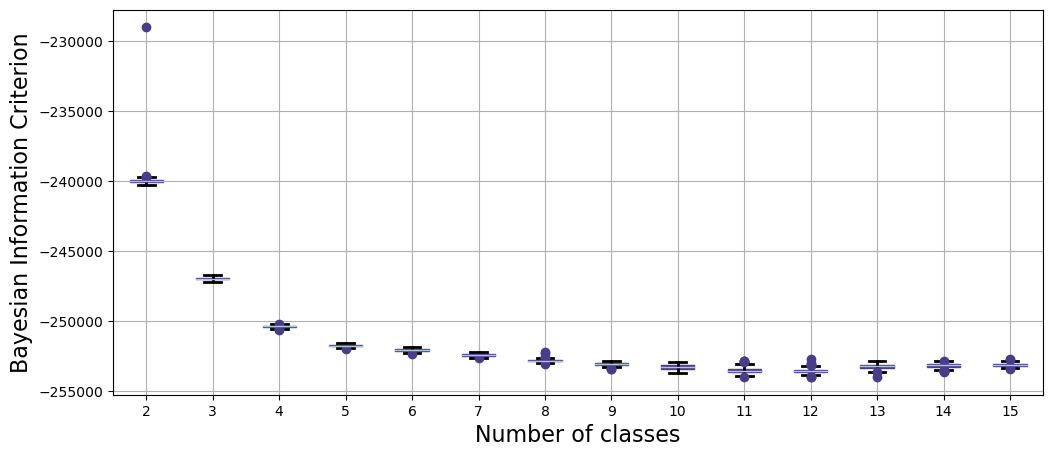

In [8]:
# BIC
fig, ax = plt.subplots()
fig.set_figwidth(width)
fig.set_figheight(height)

bp1 = plt.boxplot(bic.transpose(), positions = classes, labels = classes, widths = dK/2, patch_artist = True,
           boxprops=dict(facecolor=c1, color=c1), capprops=dict(linewidth = 2), whiskerprops=dict(linewidth = 2),
            flierprops=dict(fillstyle = 'full', markerfacecolor=c1, markeredgecolor=c1),
            medianprops=dict(color=c2));
plt.grid()

plt.xlabel('Number of classes', fontsize = 16)
plt.ylabel('Bayesian Information Criterion', fontsize = 16)

fig.savefig(figs + '_BIC.png')

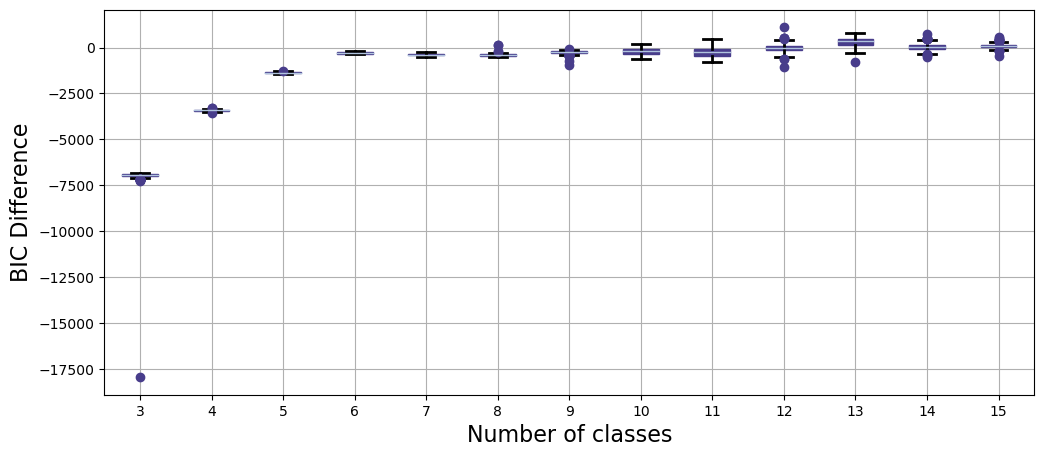

In [9]:
# BIC elbow
bic_diff = np.diff(bic, axis = 0)

fig, ax = plt.subplots()
fig.set_figwidth(width)
fig.set_figheight(height)

bp1 = plt.boxplot(bic_diff.transpose(), positions = classes[1:], labels = classes[1:], widths = dK/2, patch_artist = True,
           boxprops=dict(facecolor=c1, color=c1), capprops=dict(linewidth = 2), whiskerprops=dict(linewidth = 2),
            flierprops=dict(fillstyle = 'full', markerfacecolor=c1, markeredgecolor=c1),
            medianprops=dict(color=c2));
plt.grid()

plt.xlabel('Number of classes', fontsize = 16)
plt.ylabel('BIC Difference', fontsize = 16)

fig.savefig(figs + '_BICelbow.png')

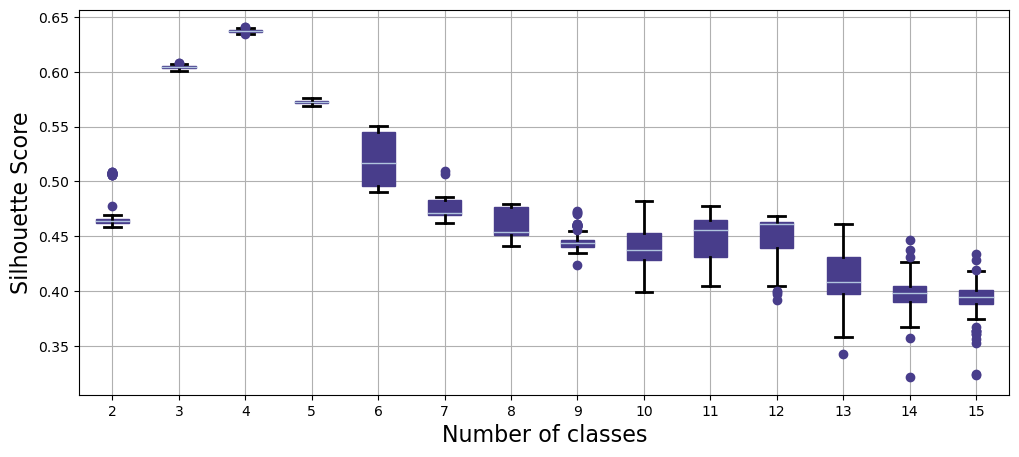

In [10]:
# silhouette score
fig, ax = plt.subplots()
fig.set_figwidth(width)
fig.set_figheight(height)

bp1 = plt.boxplot(SS.transpose(), positions = classes, labels = classes, widths = dK/2, patch_artist = True,
           boxprops=dict(facecolor=c1, color=c1), capprops=dict(linewidth = 2), whiskerprops=dict(linewidth = 2),
            flierprops=dict(fillstyle = 'full', markerfacecolor=c1, markeredgecolor=c1),
            medianprops=dict(color=c2));

plt.grid()

plt.xlabel('Number of classes', fontsize = 16)
plt.ylabel('Silhouette Score', fontsize = 16)

fig.savefig(figs + '_SS.png')